# Plotting videos

In [1]:
import matplotlib.pyplot as plt
from data import UCF101
plt.style.use(['science', 'nature', 'no-latex'])

train_data = UCF101('UCF-101', 'ucfTrainTestlist', 1, True)

def prepare_for_plot(frame):
    new_frame = frame.transpose(0, 1).transpose(1, 2)
    return new_frame[30:210]

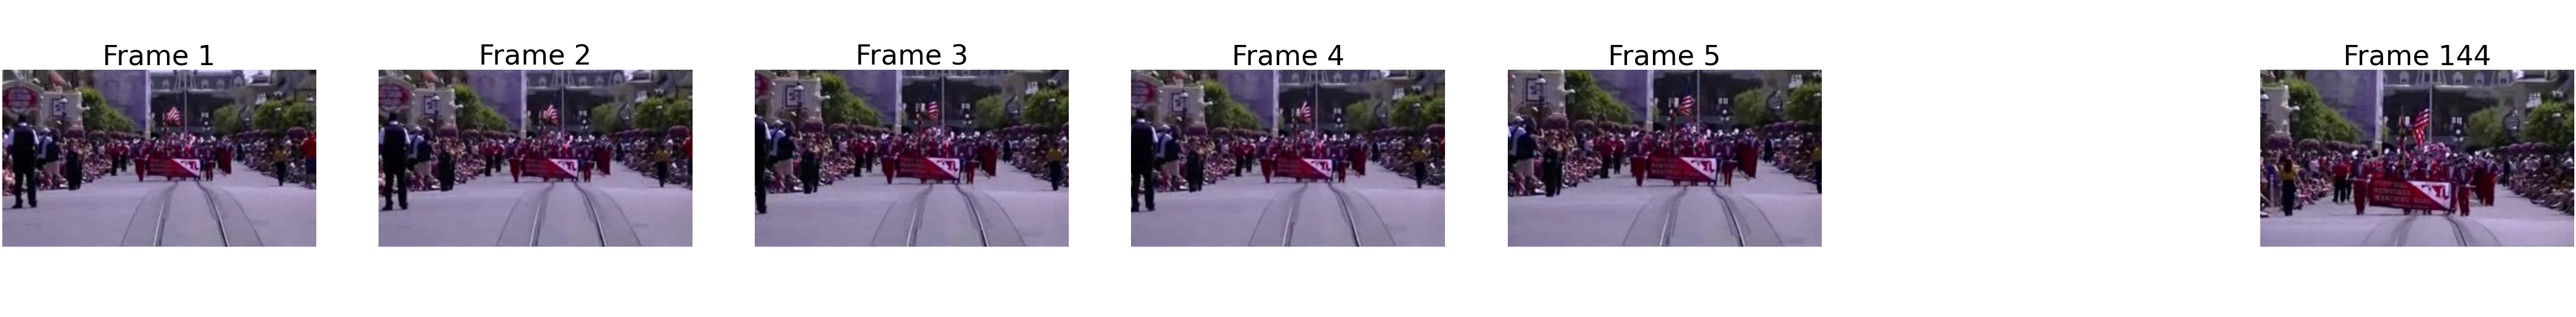

In [2]:
example = train_data[500][0]

fig, ax = plt.subplots(1, 7, figsize=(80, 10))

for axis in ax:
    axis.set_axis_off()

for i in range(5) :
    ax[i].imshow(prepare_for_plot(example[i]), interpolation='bicubic')
    ax[i].set_title(f'Frame {i+1}', fontsize=48)
    
ax[-1].imshow(prepare_for_plot(example[-1]), interpolation='bicubic')
ax[-1].set_title(f'Frame {len(example)}', fontsize=48)

fig.savefig('plots/frames.png', dpi=300, bbox_inches='tight')

# Plotting clusters

In [ ]:
import keyframes
extractor = keyframes.KeyFrameExtractor(10, 'agglomerative', True, True)
out = extractor.predict([train_features[500]])

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.colors as mcolors

def plot_kf_tsne(data, clusters, kfs):
    colors = list(mcolors.TABLEAU_COLORS.values())
    fig = plt.figure(figsize=(5, 5), dpi=300)
    transformed = TSNE(init='pca', learning_rate='auto').fit_transform(data)
    u_clusters = np.unique(clusters)

    for i in u_clusters:
        cluster_idx = np.argwhere(clusters == i).flatten()
        
        cluster_points = transformed[cluster_idx]
        
        intersection = np.intersect1d(kfs, cluster_idx)
        
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=i, color=colors[i])
        plt.scatter(transformed[intersection, 0], transformed[intersection, 1],label=i, edgecolor='black', color=colors[i])
    
    plt.title('Clusters of frames, key frames with black border')
    fig.savefig('plots/clusters.png', dpi=300, bbox_inches='tight')

plot_kf_tsne(train_features[500], out[0]['clusters'], out[0]['keyframes'])

# Plot data augmentation

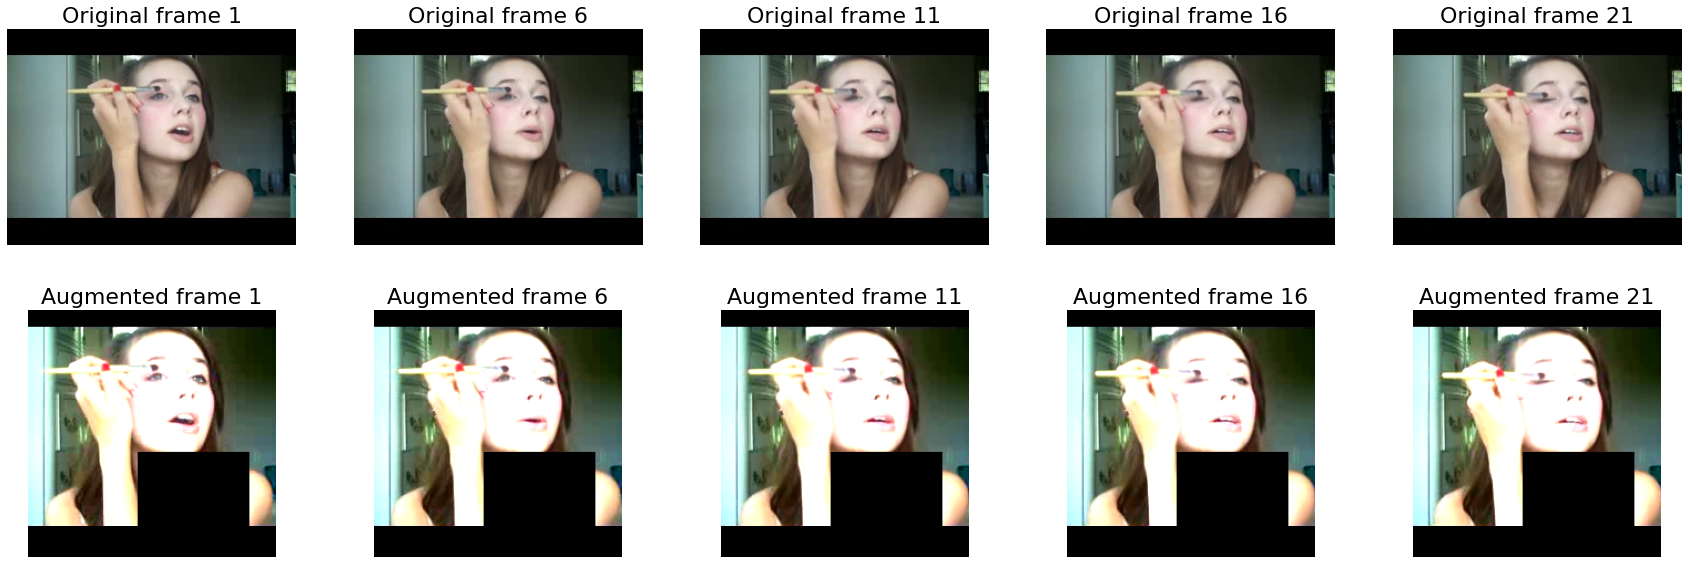

In [39]:
from data import BaselineUCF101, UCF101
import matplotlib.pyplot as plt
from einops import rearrange
import torch
from torchvision import transforms
import torch.nn.functional as F

INPUT_SHAPE = (32, 224, 224, 3)

t = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomCrop(size=INPUT_SHAPE[1:-1], pad_if_needed=True, fill=0, padding_mode='constant'),
    transforms.ColorJitter(brightness=[1.0, 1.5], contrast=[1.0, 1.5], saturation=[1.0, 1.5]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2)),
])


normal_data = UCF101('UCF-101', 'ucfTrainTestlist', 1, True)
normal = normal_data[0][0]
augmented = t(normal)


fig, ax = plt.subplots(2, 5, figsize=(30, 10))

for axis in ax.flatten():
    axis.set_axis_off()

for i in range(5):
    frame_id = i*5
    normal_frame = rearrange(normal, 'b c h w -> b h w c')[frame_id]
    augmented_frame = rearrange(augmented, 'b c h w -> b h w c')[frame_id]
    
    ax[0][i].imshow(normal_frame)
    ax[0][i].set_title(f'Original frame {frame_id+1}', fontsize=22)
    ax[1][i].imshow(augmented_frame)
    ax[1][i].set_title(f'Augmented frame {frame_id+1}', fontsize=22)

In [40]:
fig.savefig('plots/augmented_frames.png', dpi=300, bbox_inches='tight')

# Plot video duration distribution

In [9]:
from data import UCF101
from tqdm.auto import tqdm

train_data = UCF101('UCF-101', 'ucfTrainTestlist', 1, True)
test_data = UCF101('UCF-101', 'ucfTrainTestlist', 1, False)

train_data_durations = [(x.shape[0], y) for x, y in tqdm(train_data, total=len(train_data))]    
test_data_durations = [(x.shape[0], y) for x, y in tqdm(test_data, total=len(test_data))]    

  0%|          | 0/9537 [00:00<?, ?it/s]

  0%|          | 0/9537 [00:00<?, ?it/s]

Text(0.5, 1.05, 'Distribution of video durations (in number of frames)')

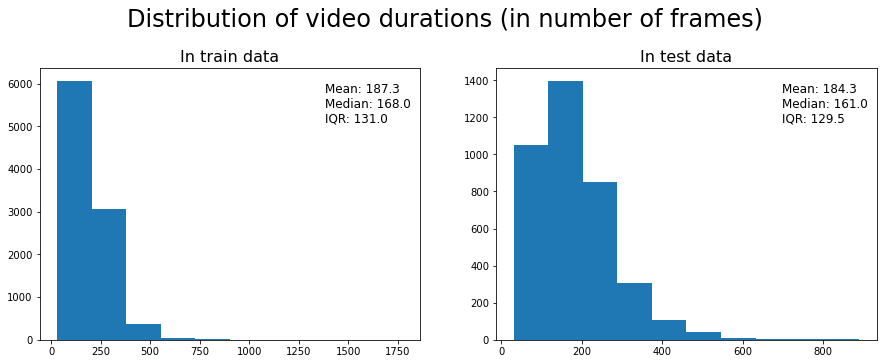

In [77]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy import stats

train_dur = [x for x, _ in train_data_durations]
test_dur = [x for x, _ in test_data_durations]

train_dur_mean = np.round(np.mean(train_dur), 1)
train_dur_median = np.round(np.median(train_dur), 1)
train_dur_iqr = stats.iqr(train_dur)
test_dur_mean = np.round(np.mean(test_dur), 1)
test_dur_median = np.round(np.median(test_dur), 1)
test_dur_iqr = stats.iqr(test_dur)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(train_dur)
ax[1].hist(test_dur)

ax[0].text(0.75, 0.8, f'Mean: {train_dur_mean}\nMedian: {train_dur_median}\nIQR: {train_dur_iqr}', transform=ax[0].transAxes, fontsize=12)
ax[1].text(0.75, 0.8, f'Mean: {test_dur_mean}\nMedian: {test_dur_median}\nIQR: {test_dur_iqr}', transform=ax[1].transAxes, fontsize=12)


ax[0].set_title('In train data', fontsize=16)
ax[1].set_title('In test data', fontsize=16)

fig.suptitle('Distribution of video durations (in number of frames)', fontsize=24, y=1.05)

In [78]:
fig.savefig('plots/video_durations.png', dpi=300, bbox_inches='tight')